# CTRL+ALT+PLAY: Predictor de afición a Videojuegos

Nuestro proyecto busca entrenar una IA la cual nos ayude a hacer una estimación sobre una muestra de personas cuyo hobby son los videojuegos y cuanto tiempo dedican a esta actividad, la cual se puede aplicar en empresas dedicadas a esta industria para estimar cual podría ser el nivel de la aceptación y la posible distribución de los mismos en los proyectos en ejecución creando experiencias más adaptadas a sus usuarios.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ai-uis-student/plojecto/online_gaming_behavior_dataset.csv')

##Utils

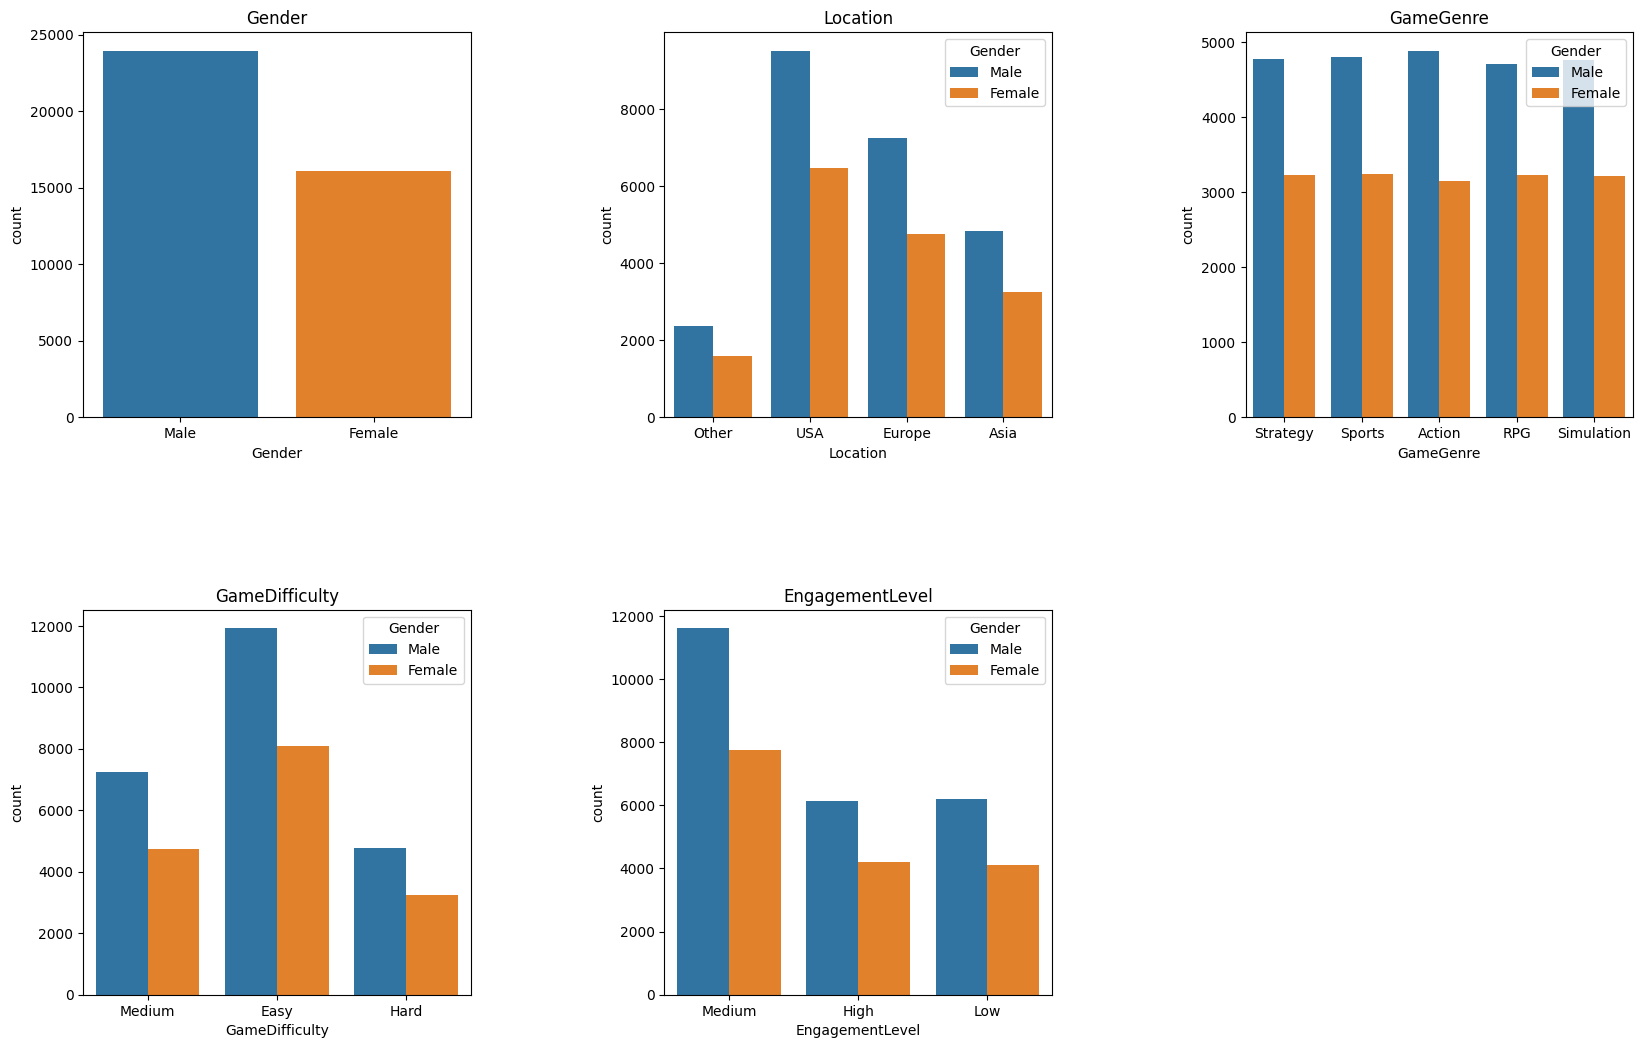

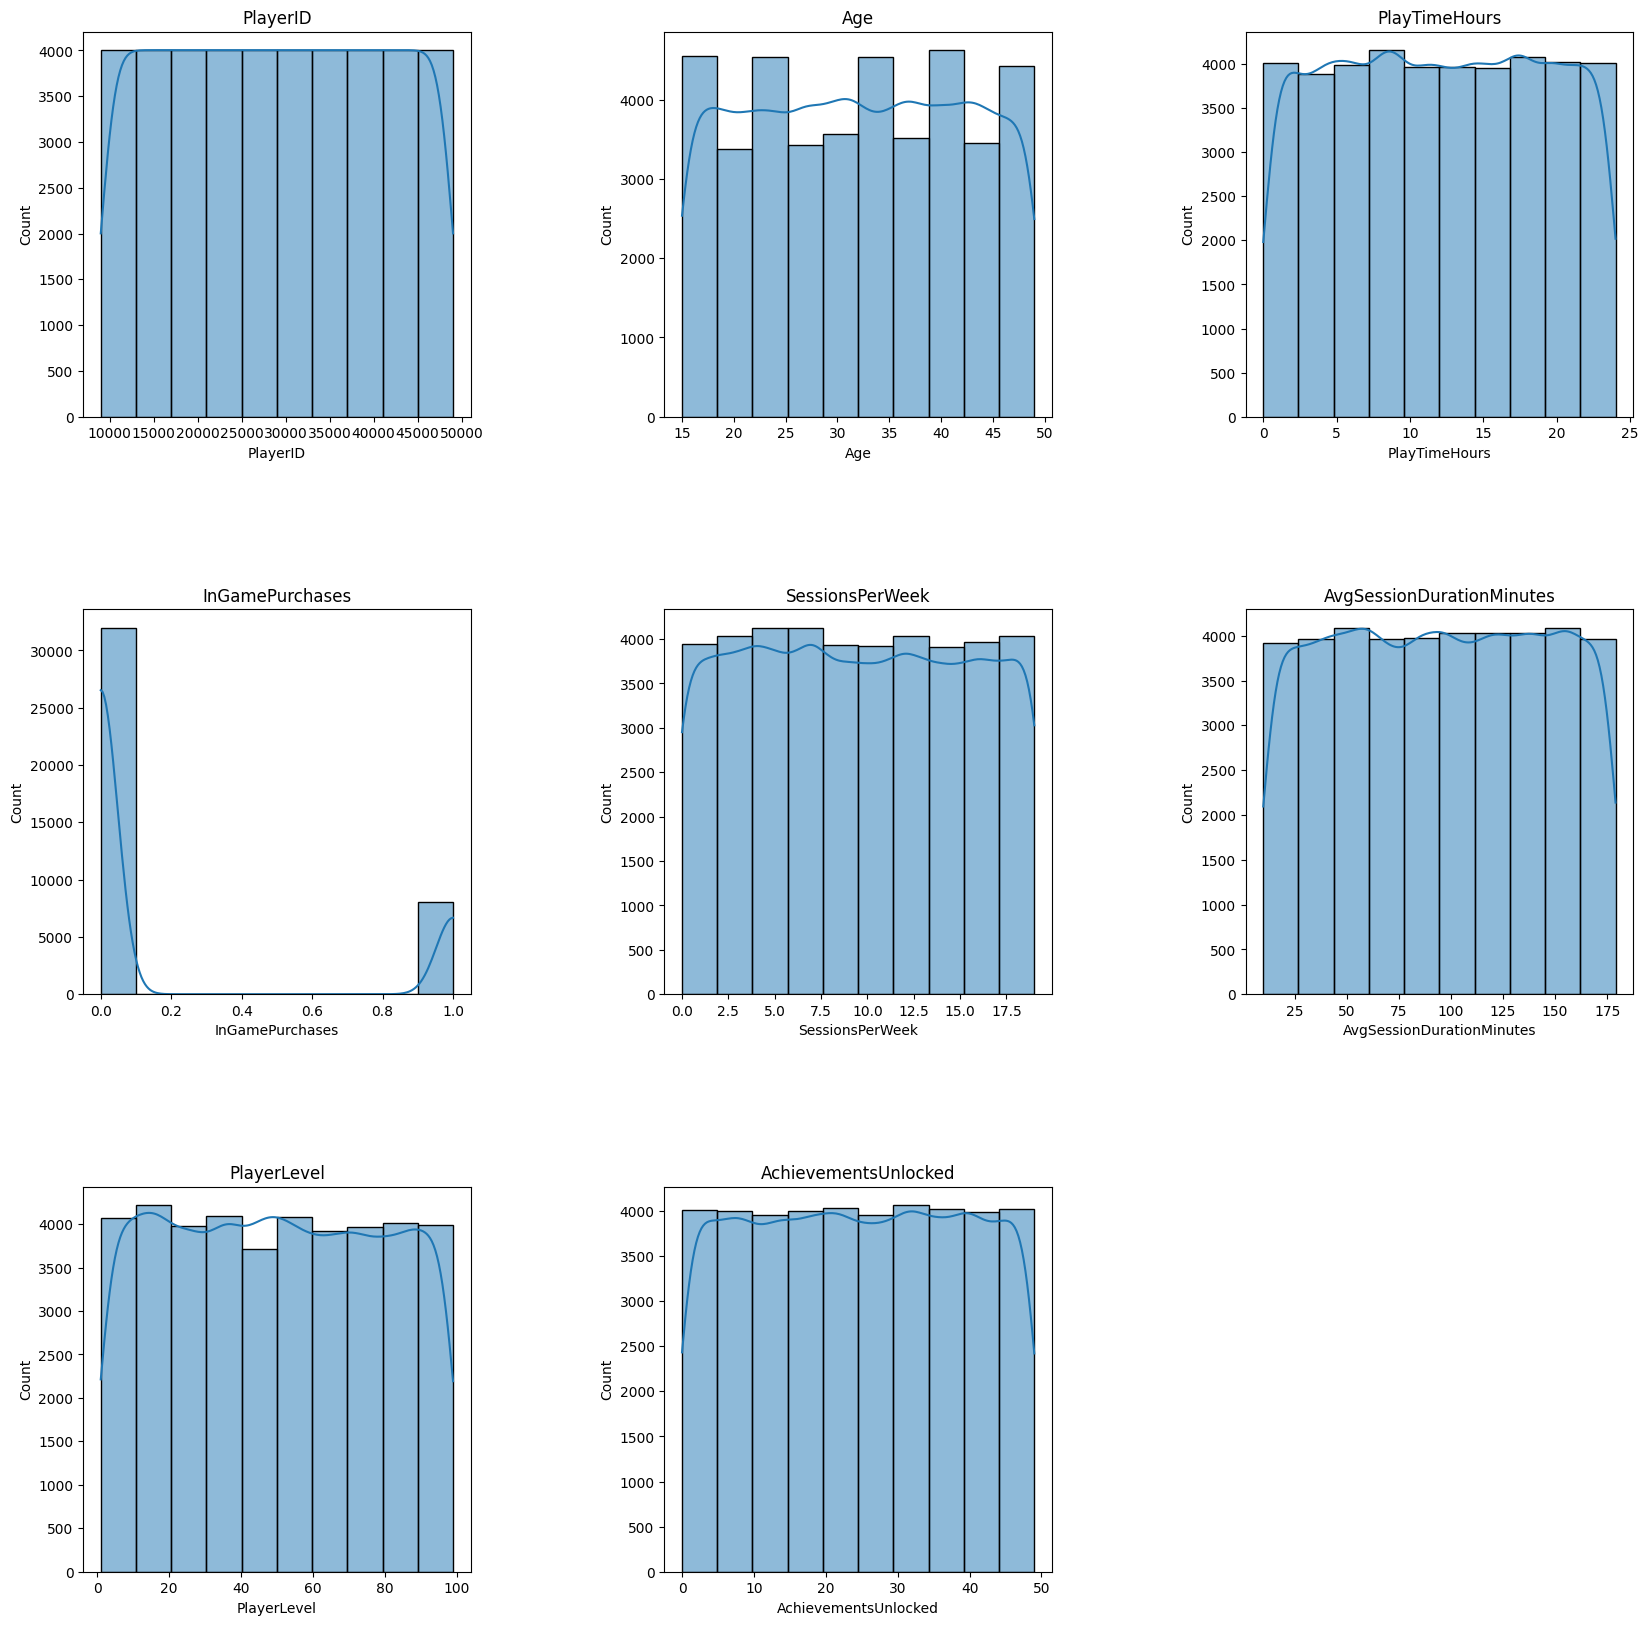

In [ ]:
def plot_grid(df, what='categorical'):
  """Plots all columns of a DataFrame in a square grid of subplots."""
  if what == 'categorical':
    df = df.select_dtypes(include=['object'])
  elif what == 'numerical':
    df = df.select_dtypes(include=['number'])
  num_cols = len(df.columns)
  grid_size = int(math.ceil(math.sqrt(num_cols)))

  fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20))
  fig.subplots_adjust(hspace=0.5, wspace=0.5)

  for i, col in enumerate(df.columns):
    row = i // grid_size
    col_idx = i % grid_size
    ax = axes[row, col_idx]

    # Choose plot type based on data type
    if pd.api.types.is_numeric_dtype(df[col]):
      sns.histplot(df[col], ax=ax, bins=10, kde=True)
    else:
      sns.countplot(x=df[col], ax=ax, hue=df['Gender'])

    ax.set_title(col)

  # Hide any unused subplots
  for i in range(num_cols, grid_size * grid_size):
    row = i // grid_size
    col_idx = i % grid_size
    fig.delaxes(axes[row, col_idx])

  plt.show()

plot_grid(df, 'categorical')
plot_grid(df, 'numerical')


#Preprocesamiento

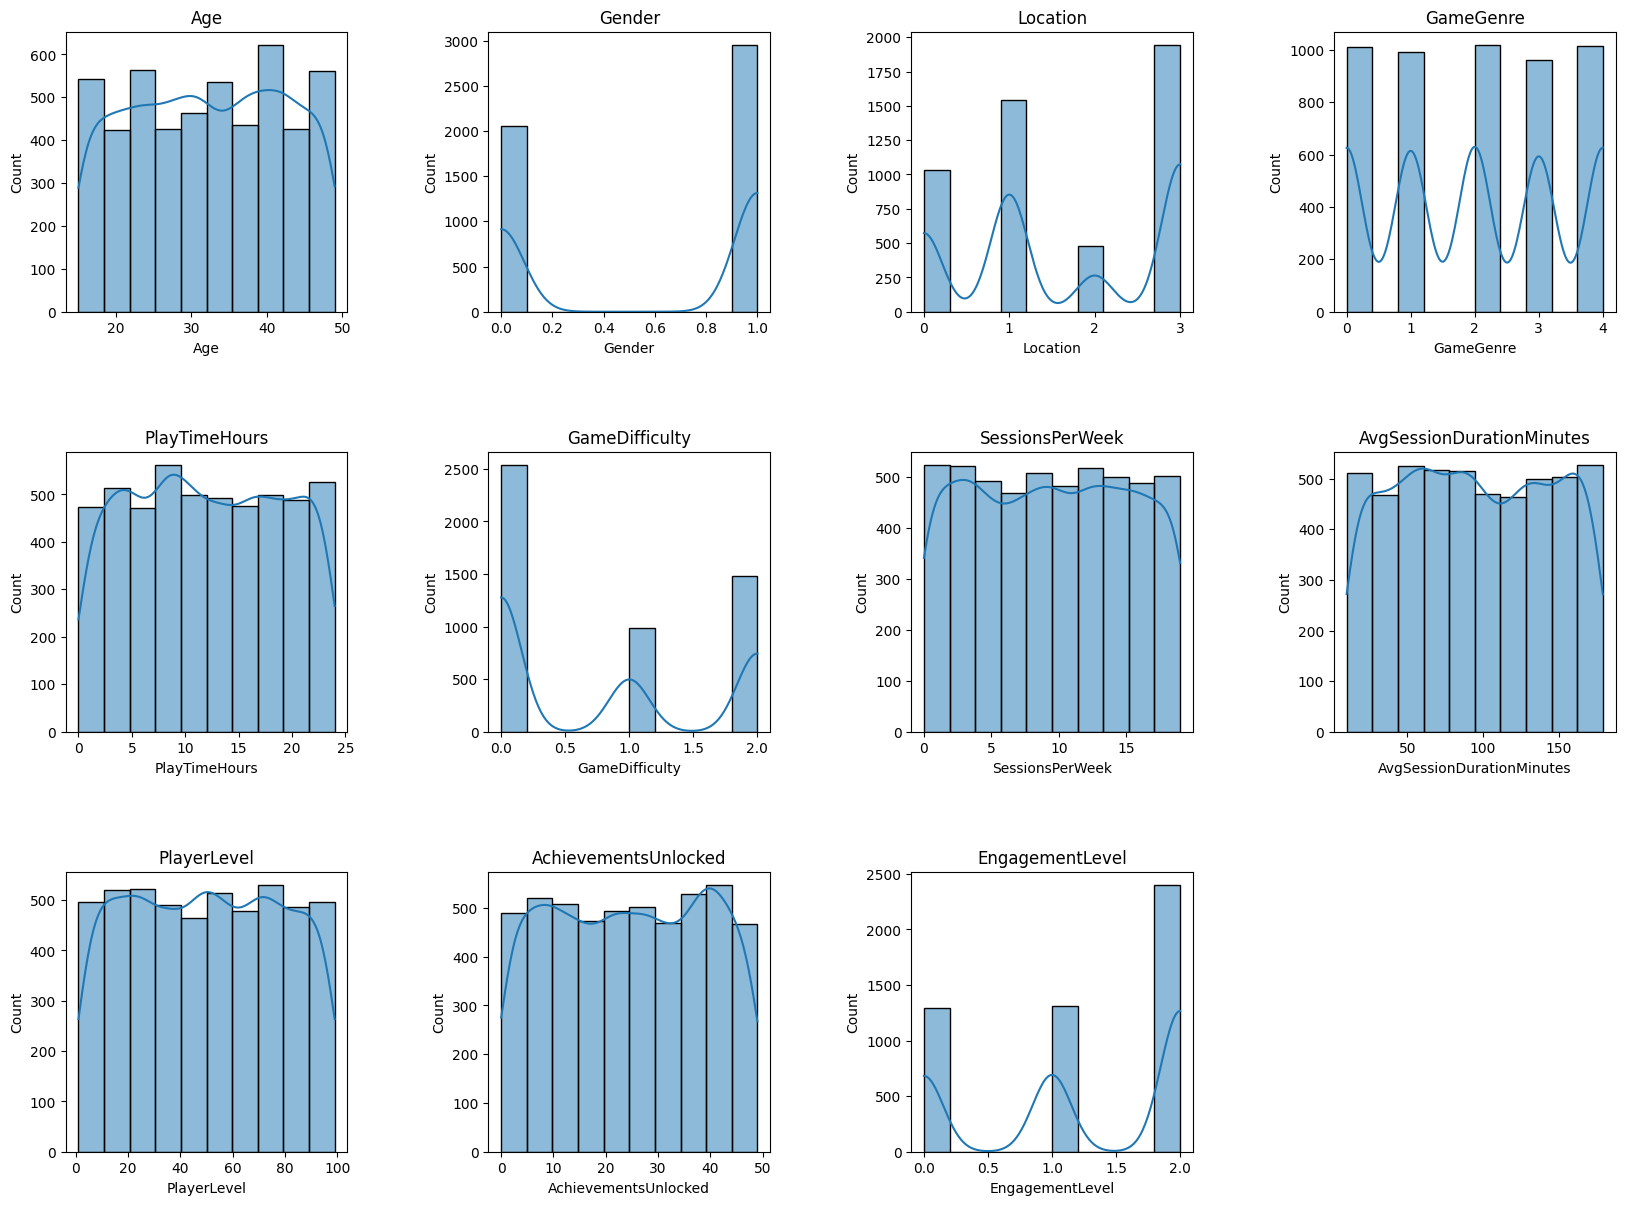

In [ ]:
# InGamePurchases es medio inutil, y tambien el PlayerID
df = df.drop(['InGamePurchases', 'PlayerID'], axis=1)
df.head()

#Convert categorical columns to numerical

from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Iterate over the categorical columns and apply Label Encoding
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

# Downsampling
sample_size = 5000
weights = np.random.normal(loc=0.5, scale=0.1, size=len(df))
weights = weights / weights.sum()
df = df.sample(n=sample_size, weights=weights, random_state=42)
plot_grid(df, 'numerical')

#Entrenamiento
<img src="https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExdnphdnpiOG1zM3l2aG9lOHYyMzByOW5kNzVwaTlkODBwN3p3Z3dqeCZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/hqTguNdEoA1ooYxeog/giphy.gif" width=320>

Nuestro proyecto es de regresion lineal asi que nuestro $y$ debe ser numerico (por eso se codificaron las columnas categoricas como numericas)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

x = df.drop('PlayTimeHours', axis=1)
y = df['PlayTimeHours']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) #Particion 80/20

In [ ]:
def show_curve_crossval(est):
    means, stds = [], []
    nfolds_range = range(2,10)
    for nfolds in nfolds_range:
        #print (nfolds,)
        s = cross_val_score(model, x, y, cv=KFold(nfolds, shuffle=True), scoring=make_scorer(mean_squared_error))
        means.append(np.mean(s))
        stds.append(np.std(s))

    means = np.r_[means]
    stds  = np.r_[stds]

    plt.plot(nfolds_range, means, label="mean", color="black")
    plt.fill_between(nfolds_range, means-stds, means+stds, color="blue", alpha=.5, label="std")
    plt.xlabel("n folds")
    plt.ylabel("performance")
    plt.legend()

In [ ]:
def show_curve_train_test(est, X_train, X_test, y_train, y_test):
    stds, scores = [], []
    nfolds_range = range(10,101,10)

    for nfolds in range(10,101,10):

        if est == 'DecisionTreeRegressor':
            model = DecisionTreeRegressor(max_depth=nfolds)
        else:
          model = RandomForestRegressor(n_estimators=nfolds)

        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        scores.append(mean_squared_error(y_test, pred))
        stds.append(np.std(scores))

    stds  = np.r_[stds]
    scores = np.r_[scores]

    plt.plot(nfolds_range, scores, label="mean", color="black")
    plt.fill_between(nfolds_range, scores-stds, scores+stds, color="blue", alpha=.5, label="std")
    plt.xlabel("n estimators/max_depth")
    plt.ylabel("performance")
    plt.legend()

##Decision tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

model = DecisionTreeRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

cv_scores = cross_val_score(model, x, y, cv=3, scoring=make_scorer(mean_squared_error))

print("Mean Squared Error:", mse)
#print("Cross-Validation MSE (Media):", np.mean(cv_scores))
#print("Cross-Validation MSE (Desviación estándar):", np.std(cv_scores))


Mean Squared Error: 93.28862574549139


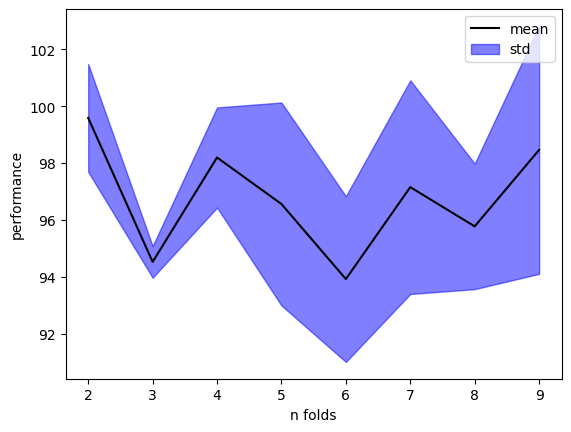

In [ ]:
show_curve_crossval(DecisionTreeRegressor())

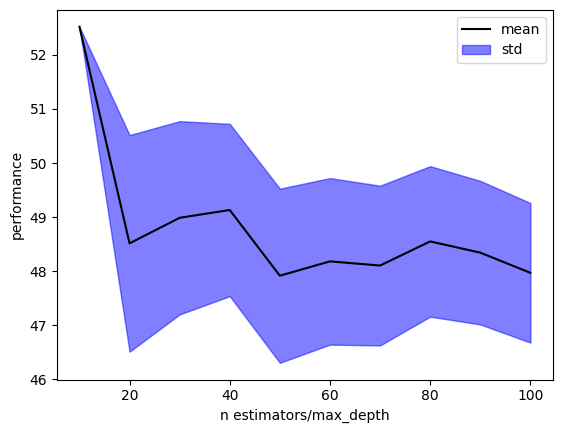

In [ ]:
show_curve_train_test('DesicionTreeRegressor', x_train, x_test, y_train, y_test)

In [ ]:
new_data = pd.DataFrame({
    'Age': [60],
    'Gender': [1],
    'Location': [0],
    'GameGenre': [2],
    'GameDifficulty': [1],
    'SessionsPerWeek': [4],
    'AvgSessionDurationMinutes':[30],
    'PlayerLevel':[50],
    'AchievementsUnlocked':[10],
    'EngagementLevel':[1]
})

new_prediction = model.predict(new_data)
print("Prediction:", new_prediction)

Prediction: [23.66780483]


##Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = RandomForestRegressor()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

#cv_scores = cross_val_score(model, X, y, cv=3, scoring=make_scorer(mean_squared_error))

results = {
        'MSE (Prueba)': mse,
        'MAE (Prueba)': mae,
        'RMSE (Prueba)': rmse,
        #'Cross-Validation MSE (Media)': np.mean(cv_scores),
        #'Cross-Validation MSE (Desviación estándar)': np.std(cv_scores)
}

for key, value in results.items():
    print(f"{key}: {value:.4f}")

MSE (Prueba): 48.9636
MAE (Prueba): 6.0072
RMSE (Prueba): 6.9974


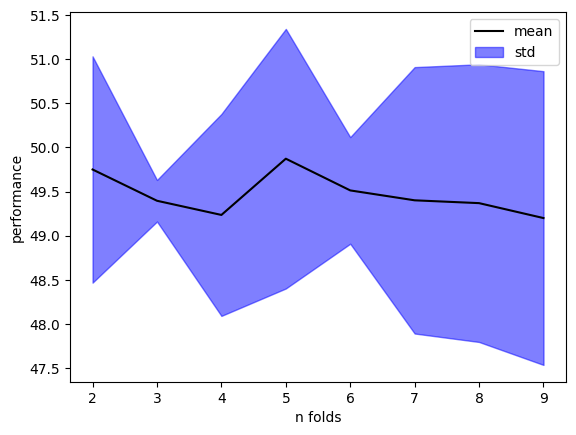

In [ ]:
show_curve_crossval(RandomForestRegressor())

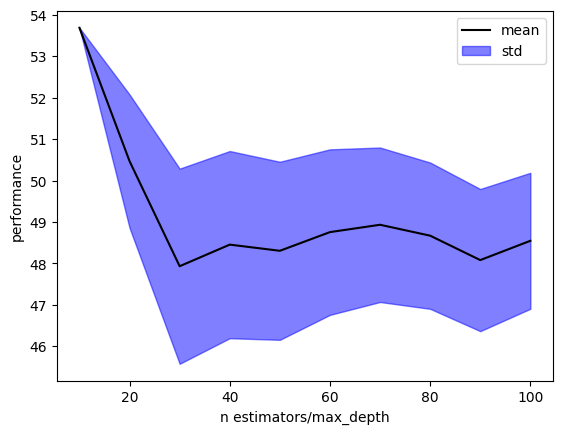

In [ ]:
show_curve_train_test('', x_train, x_test, y_train, y_test)

In [ ]:
new_data = pd.DataFrame({
    'Age': [60],
    'Gender': [1],
    'Location': [0],
    'GameGenre': [2],
    'GameDifficulty': [1],
    'SessionsPerWeek': [4],
    'AvgSessionDurationMinutes':[30],
    'PlayerLevel':[50],
    'AchievementsUnlocked':[10],
    'EngagementLevel':[1]
})

new_prediction = model.predict(new_data)
print("Prediction:", new_prediction)

Prediction: [12.80270692]


##SVM

In [ ]:
from sklearn.svm import SVR

model = SVR()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 48.36366528811025


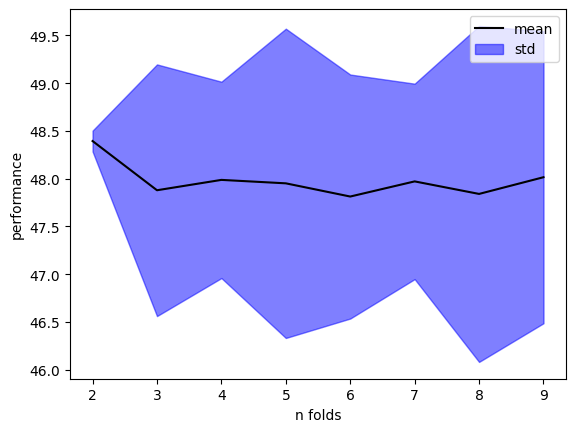

In [ ]:
show_curve_crossval(SVR())

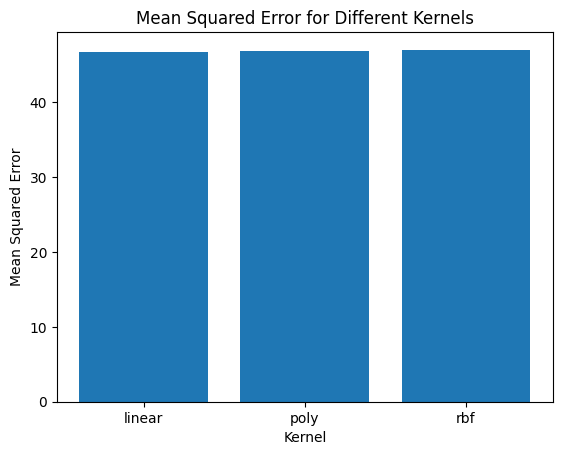

In [ ]:
#Barplots for kernels svr
def svr_plot():
  kernels = ['linear', 'poly', 'rbf']
  mse_values = []

  for kernel in kernels:
      model = SVR(kernel=kernel)
      model.fit(x_train, y_train)
      y_pred = model.predict(x_test)
      mse = mean_squared_error(y_test, y_pred)
      mse_values.append(mse)

  plt.bar(kernels, mse_values)
  plt.xlabel('Kernel')
  plt.ylabel('Mean Squared Error')
  plt.title('Mean Squared Error for Different Kernels')
  plt.show()

svr_plot()

In [ ]:
#save svm model
import pickle

with open('svm_playtime_hours.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
new_data = pd.DataFrame({
    'Age': [60],
    'Gender': [1],
    'Location': [0],
    'GameGenre': [2],
    'GameDifficulty': [1],
    'SessionsPerWeek': [4],
    'AvgSessionDurationMinutes':[30],
    'PlayerLevel':[50],
    'AchievementsUnlocked':[10],
    'EngagementLevel':[1]
})

new_prediction = model.predict(new_data)
print("Prediction:", new_prediction)

Prediction: [12.02548131]


## Perceptron

In [ ]:
import tensorflow as tf
from tensorflow import keras

# El ground truth, x y los datos de entrenamiento con proporción del 80%
# para entrenamiento y 20% para prueba, ya estan definidos anteriormente.

# 3 capas

model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(), loss='crossentropy', metrics=['mae'])
model.fit(x_train, y_train, epochs=10, verbose=1)
y_pred = model.predict(x_test, verbose=1)

test_loss, test_mae_3 = model.evaluate(x_test, y_test)
print('Test MAE para 3 capas:', test_mae_3)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -136.5884 - mae: 16.5377
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -177.1083 - mae: 16.3230
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -178.0110 - mae: 16.0581
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -176.6385 - mae: 16.2116
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: -175.5809 - mae: 16.1634
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -177.8293 - mae: 16.3395
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: -177.0113 - mae: 16.3702
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -172.6310 - mae: 16.2097
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -174.6171 - mae: 16.2743
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -175.8575 - mae: 16.2669
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -180.3674 - mae: 15.7839
Test MAE para 3 capas: 16.237098693847656


In [ ]:
# 6 capas
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(), loss='crossentropy', metrics=['mae'])
model.fit(x_train, y_train, epochs=10, verbose=1)
y_pred = model.predict(x_test, verbose=1)

test_loss, test_mae_6 = model.evaluate(x_test, y_test)
print('Test MAE para 6 capas:', test_mae_6)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - loss: -173.6424 - mae: 7227.8887
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - loss: -176.8905 - mae: 7539.6348
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - loss: -177.0082 - mae: 7547.4053
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - loss: -176.0967 - mae: 7518.8970
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: -174.5921 - mae: 7525.1699
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: -175.8696 - mae: 7569.6523
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: -177.2587 - mae: 7572.1841
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: -174.4708 - mae: 7537.0630
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: -173.1930 - mae: 7527.0630
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: -172.3241 - mae: 7573.9243
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -180.3674 - mae: 7429.4067
Test 

In [ ]:
# 10 capas
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(), loss='crossentropy', metrics=['mae'])
model.fit(x_train, y_train, epochs=10, verbose=1)
y_pred = model.predict(x_test, verbose=1)

test_loss, test_mae_10 = model.evaluate(x_test, y_test)
print('Test MAE para 10 capas:', test_mae_10)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


Exception ignored in: <function _xla_gc_callback at 0x7b523c0c57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - loss: -165.0132 - mae: 7160.4136
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: -174.2421 - mae: 7434.6616
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: -173.8456 - mae: 7427.6553
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: -173.8940 - mae: 7404.6045
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: -174.9477 - mae: 7392.6040
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: -176.9808 - mae: 7510.7285
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: -175.7753 - mae: 7464.7285
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: -176.2041 - mae: 7412.0576
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: -177.8841 - mae: 7431.0288
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: -175.0504 - mae: 7446.0684
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: -180.3674 - mae: 7283.2612
Test MAE par